# Quara Questions Pairs - Case Studies

# 1. Business Problem

## 1.1 Discription

Quora is a place to gain and share knowledge-about anything. It's a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world. <br>

Over 100 million people visist Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

### >Credits: kaggle 
https://www.kaggle.com/c/quora-question-pairs

### **Problem Statement** 

<ul>
    <li>Identify which questions asked on Quora are duplicates of questions that have already been asked.</li>
     <li>This could be useful to instantly provide answers to questions that have been already answered.</li>
    <li>We are tasked with predicting whether a pair of questions are duplicates or not</li>

# 1.2 Sources/Useful Links
### source: 
https://www.kaggle.com/c/quora-question-pairs
### **Useful Links**:
##### discussion: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
##### Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
##### Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
##### Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30


<h2> 1.3 Real world/Business Objectives and Constraints</h2>

1. Cost of mis-classification can be very high.
2. Need probability of a pairs of dublicate questions to choose the proper thereshold.
3. No strict latency concers.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

[kaggle data](https://www.kaggle.com/c/quora-question-pairs)<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3><br>
 It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.



<h3> 2.2.2 Performance Metric </h3>

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

<h1>3. Exploratory Data Analysis </h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import os
import gc # gabage collector

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h3> 3.1.0 Reading Data</h3>

In [3]:
df = pd.read_csv('train.csv')
print("No of data points :", df.shape[0])

No of data points : 404290


In [4]:
# data overviews
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are a given minimal number of data fields here, consisting of :
* id : looks likes a simple id
* qid{1,2}: The unique id of each question in the pair
* question{1,2}: The actuall textual content of the questions
* is_duplicate: The label that we are trying to predict- whether the two questions are duplicate or not


<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

<AxesSubplot:xlabel='is_duplicate'>

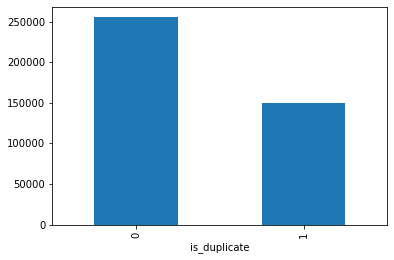

In [16]:
df.groupby(by = 'is_duplicate')['id'].count().plot.bar()

In [17]:
print("~> Total number of question pairs for training \n", len(df))

~> Total number of question pairs for training 
 404290


In [22]:
print('~> Question pairs are not duplicate (is_duplicate = 0):\n {}%'.format(100-round(df['is_duplicate'].mean()*100,2)))
print('~> Question pairs are duplicate (is_duplicate = 1):\n {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not duplicate (is_duplicate = 0):
 63.08%
~> Question pairs are duplicate (is_duplicate = 1):
 36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [39]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)
print("Total number of unique questions: ", unique_qs)
print("Total number of questions including similar and non-similar :", len(qids))
print('Percentage of unique questions is: {}%'.format(round(unique_qs/len(qids)*100, 2)))
print("Number of questions that appear more than one time : {} ({}%): ".format(qs_morethan_onetime, qs_morethan_onetime/unique_qs*100))
print("maximum number of times a question is repeated: {}".format(max(qids.value_counts())))

Total number of unique questions:  537933
Total number of questions including similar and non-similar : 808580
Percentage of unique questions is: 66.53%
Number of questions that appear more than one time : 111780 (20.77953945937505%): 
maximum number of times a question is repeated: 157


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



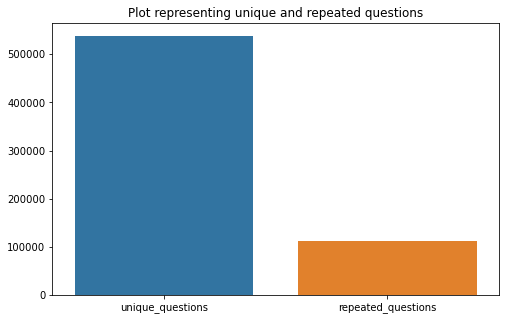

In [45]:
x = ['unique_questions','repeated_questions']
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize=(8,5))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

<h3> 3.2.3 Checking for Duplicates Entry into the data fields </h3>

In [48]:
pair_duplicates = df[['qid1','qid2', 'is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions: ", (pair_duplicates.shape[0]-df.shape[0]))

Number of duplicate questions:  0


<h3> 3.2.4 Number of occurrences of each question </h3>


Maximum number of times a single question is repeated: 157


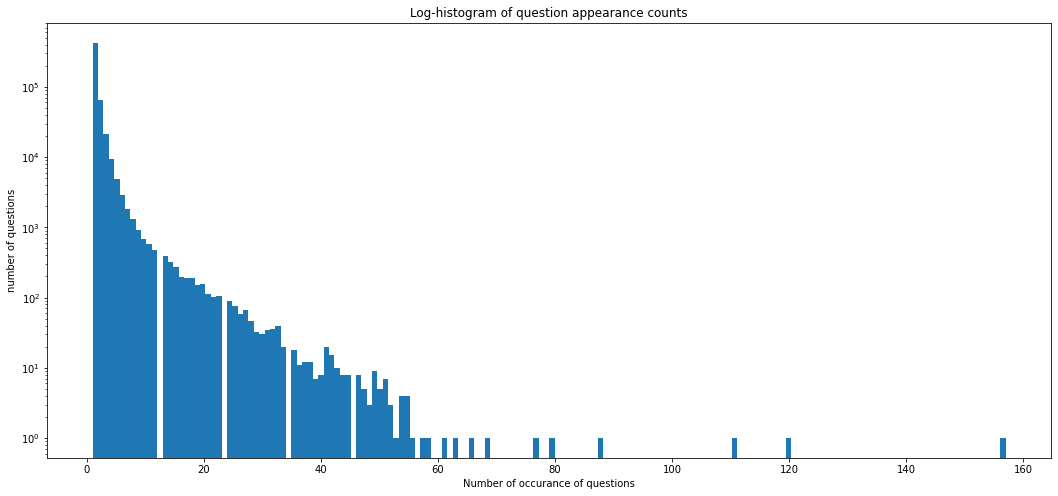

In [58]:
plt.figure(figsize=(18,8))
plt.hist(qids.value_counts(),bins=170)

plt.yscale("log", nonpositive='clip') # symmetrical log don't take additional argument ("symlog")
plt.title("Log-histogram of question appearance counts")
plt.xlabel('Number of occurance of questions')
plt.ylabel("number of questions")

print("Maximum number of times a single question is repeated: {}".format(max(qids.value_counts())))

<h3> 3.2.5 Checking for NULL values </h3>

In [8]:
# checking whethere there is any null value or not
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- **There are two rows with null values in question2 and one in question1**

In [9]:
# filling null value with empty string as no of null value is very less
# we can either avoid these rows
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>


Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of unique words in Question 1 + Total num of unique words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [19]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding = 'latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count') 
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()    
    df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row : len(row.split(" ")))
    
    # finding common words
    def normalized_common_word(row):
        w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1 & w2)
    df['word_Common'] = df.apply(normalized_common_word,axis=1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
        return 1.0*(len(w1)+len(w2))
    df['word_Total'] = df.apply(normalized_word_Total,axis = 1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1 & w2)/(len(w1)+len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis= 1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    
    df.to_csv('df_fe_without_preprocessing_train.csv', index = False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [22]:
print("minimum length of the questions in question1: ", min(df['q1_n_words']))
print("minimum length of the questions in question2: ", min(df['q2_n_words']))

print("number of questions with minmum length [question1]: ", df[df['q1_n_words']==1].shape[0])
print("number of questions with minmum length [question2]: ", df[df['q2_n_words']==1].shape[0])

minimum length of the questions in question1:  1
minimum length of the questions in question2:  1
number of questions with minmum length [question1]:  67
number of questions with minmum length [question2]:  24


<h4> 3.3.1.1 Feature: word_share </h4>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



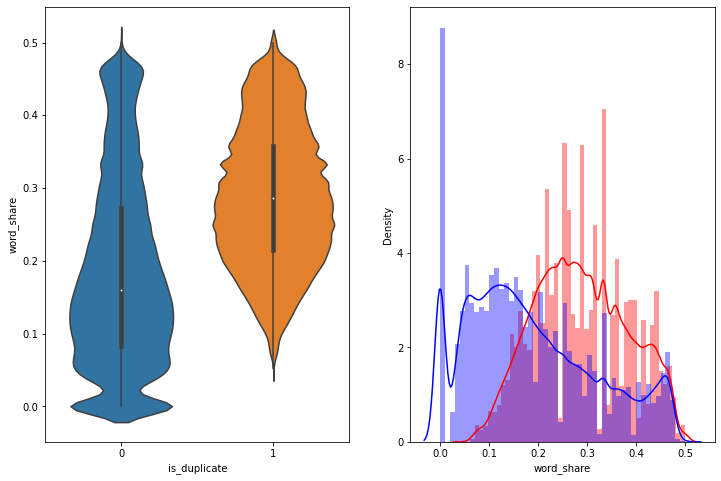

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()



**The distirbutions for normalized word_share have some overlaps on the far right-hand side, i.e, there are quite a lot of question with high word similarity**

**The average word share and Common no of words of qid1 and qid2 is more when they are duplicate (similar)**

<h4> 3.3.1.2 Feature: word_Common </h4>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



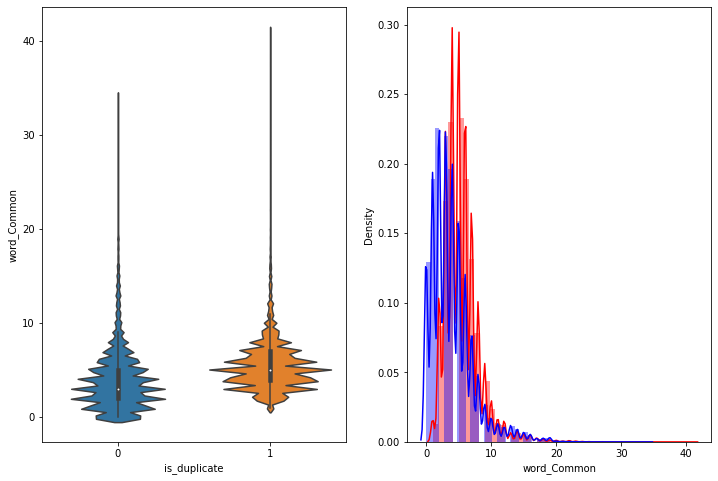

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**The distributions of the word_Common feature in similar and non-similar questions are highly overlapping**